# Определение возраста покупателей

<span style="color:green">
<h4>Описание проекта</h4>
Для сетевого супермаркета построить модель, которая по фотографии определит приблизительный возраст человека. Для этого:<br>
- провести исследовательский анализ набора фотографий<br>
- подготовить данные к обучению<br>
- обучить сверточную нейронную сеть и рассчитать ее качество
</span>

## Исследовательский анализ данных

<span style="color:green">
Прежде всего импортируем все модули и библиотеки, которые могут понадобиться нам для работы
</span>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import pandas as pd

<span style="color:green">
В начале, считаем данные по фотографиям, и посмотрим на распеределение возрастов из датасета (будет приведен код, отработанный на тренажере)
</span>

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

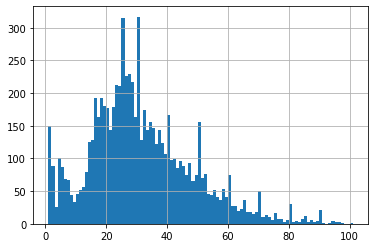

In [3]:
# Выведем гистограмму распределения возрастов
data['real_age'].hist(bins=100, range=(1,101));

<span style="color:green">
Как можно видеть максимум значений возрасов приходится на период от 25 до 30 лет. При этом, количество фотографий людей старше 60 весьма мало, что может привести к ошибкам обученной сети в виду малого объема обучающей выборке на данном учебном датасете
</span>

<span style="color:green">
В данной выборке заметны пики в значениях - 1, 5, 16, 18, 25, 30, 40, 50, 60, 70, 80, 90 лет. Скорее всего, это связано с особенностями разметки датасета, так как скорее всего могли быть случаи, когда data инженер не знал точное число лет человека на фотографии, и поэтому использовал наиболее характерные возрасты. То есть 1 год - практически любой совсем маленький ребенок, 5 лет - абстрактный дошкольник, 16 и 18 лет - характерные возрасты для подростков, 25, 30, 40 и т.д. - психологическая градация людей разный возрастов (как и в жизни - мы не говорим, что человеку 43 или 38, а говорим, как "около сорока")
</span>

<span style="color:green">
Также рассмотрим, какие изображения нам придется анализировать
</span>

In [4]:
# Создаем data генератор
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

# С помощью итератора формируем вывод батчей изображений и их меток
features, target = next(datagen_flow)

Found 5694 images belonging to 1 classes.


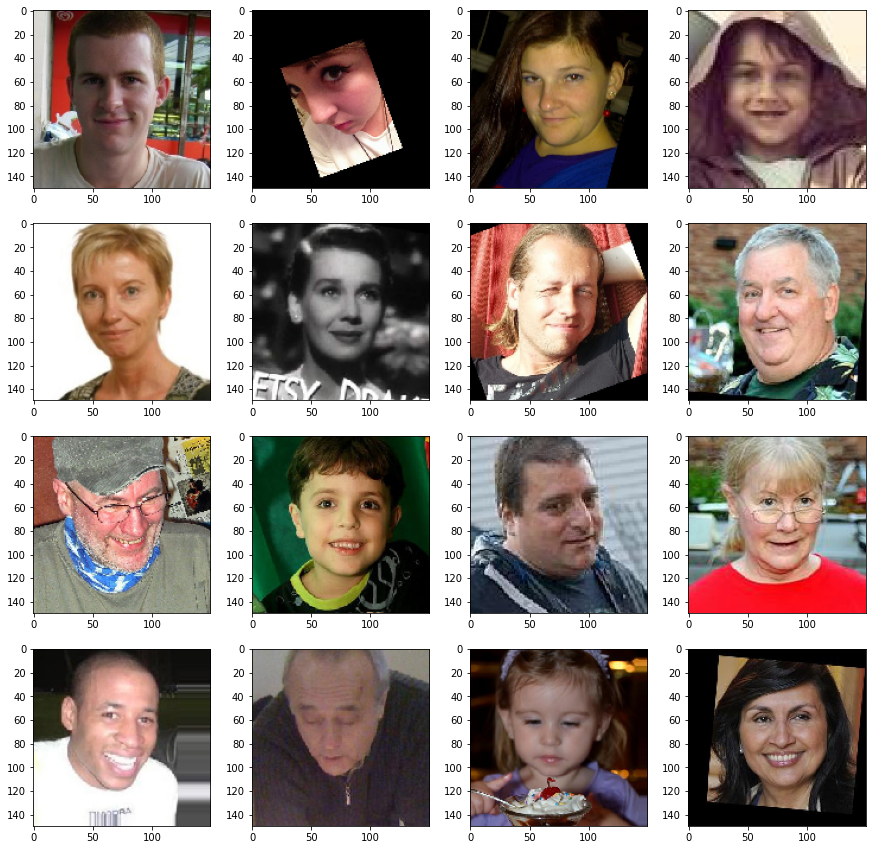

In [5]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
ax[0,0].imshow(features[0,:,:,:]);
ax[0,1].imshow(features[1,:,:,:]);
ax[0,2].imshow(features[2,:,:,:]);
ax[0,3].imshow(features[3,:,:,:]);
ax[1,0].imshow(features[4,:,:,:]);
ax[1,1].imshow(features[5,:,:,:]);
ax[1,2].imshow(features[6,:,:,:]);
ax[1,3].imshow(features[7,:,:,:]);
ax[2,0].imshow(features[8,:,:,:]);
ax[2,1].imshow(features[9,:,:,:]);
ax[2,2].imshow(features[10,:,:,:]);
ax[2,3].imshow(features[11,:,:,:]);
ax[3,0].imshow(features[12,:,:,:]);
ax[3,1].imshow(features[13,:,:,:]);
ax[3,2].imshow(features[14,:,:,:]);
ax[3,3].imshow(features[15,:,:,:]);

<span style="color:green">
Даже первые 16 изображений показывают, что нам не придется делать дополнительные аугментации картинок, так как среди них уже есть повернутые, черно-белые, размытые, низкого и высокого разрешения
</span>

## Обучение модели

```python

# Создадим функции, которые с помощью дата генераторов подготовят нам данные для обучения нейронных сетей (батчи изображений на вход и лейблы с возрастами для оценки корректности выхода сети) - тренировочные и тестовые данные
def load_train(path):
    data = pd.read_csv(path+'/labels.csv')

    print('Start load_train')

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=8,
        horisontal_flip=True,
        class_mode='raw',
        subset='training',
        seed=12345)
    print('load_train done')
    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path+'/labels.csv')

    print('Start load_test')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=8,
        horisontal_flip=True,
        class_mode='raw',
        subset='validation',
        seed=12345)

    print('load_test done')
    return test_datagen_flow

# Сгенерируем модель сверточной нейронной сети на основе архитектуры ResNet50
#
#
# Особенностями данной модели будут следующие моменты:
# - для сети буедт использоваться уже готовый набор весов, полученный при обучении на датасете ImageNet. Поскольку, если взять "чистую" сеть, то с большой вероятностью объема датасета с лицами попросту не хватит для достаточного обучения сети
# - сеть будет скорректирована так: выходные 1000 softmax узлов будут заменены одним ReLU узлом, который будет ормировать выходное значение возраста от 1 до 100
# - для обучения сети, веса основной ее части не будут заморахиваться. Поскльку если их заморозить, и оставить на обучение только веса ребер, инцидентных выходному узлу, то сеть с большой долей вероятности переобучится, а если после "разогрева" сети, снова размораживать веса основной части сети - то получим результат несколько лучший, чем если заморозку не делать, но потратим больше времени на обучение (которое у нас ограничено)
# - оптимизатор Adam, функция потерь - MSE, метрика качества обучения сети - MAE
def create_model(input_shape):

    print('Start create model')

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    #backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    
    print('Model was created')

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    print('Start train model')

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

<span style="color:green">
Перепишем вывод результат на экран для сверточной сети
</span>

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Model was created
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Start train model
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 712 steps, validate for 238 steps
Epoch 1/10
2022-10-27 19:05:18.918647: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-27 19:05:20.925074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
712/712 - 68s - loss: 200.3790 - mean_absolute_error: 10.5241 - val_loss: 288.7767 - val_mean_absolute_error: 13.0545
Epoch 2/10
712/712 - 41s - loss: 80.9851 - mean_absolute_error: 6.8815 - val_loss: 99.0267 - val_mean_absolute_error: 7.5748
Epoch 3/10
712/712 - 41s - loss: 41.2869 - mean_absolute_error: 4.9859 - val_loss: 77.5277 - val_mean_absolute_error: 6.7481
Epoch 4/10
712/712 - 41s - loss: 26.8314 - mean_absolute_error: 3.9824 - val_loss: 91.1818 - val_mean_absolute_error: 7.2538
Epoch 5/10
712/712 - 43s - loss: 21.3423 - mean_absolute_error: 3.5332 - val_loss: 92.1797 - val_mean_absolute_error: 7.1321
Epoch 6/10
712/712 - 43s - loss: 18.6736 - mean_absolute_error: 3.3091 - val_loss: 78.6986 - val_mean_absolute_error: 6.7950
Epoch 7/10
712/712 - 43s - loss: 17.2812 - mean_absolute_error: 3.1816 - val_loss: 76.8183 - val_mean_absolute_error: 6.5182
Epoch 8/10
712/712 - 43s - loss: 16.0236 - mean_absolute_error: 3.0365 - val_loss: 74.3967 - val_mean_absolute_error: 6.6284
Epoch 9/10
712/712 - 43s - loss: 13.9926 - mean_absolute_error: 2.8587 - val_loss: 75.8973 - val_mean_absolute_error: 6.5394
Epoch 10/10
712/712 - 41s - loss: 12.6722 - mean_absolute_error: 2.7063 - val_loss: 72.1127 - val_mean_absolute_error: 6.3003
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 10s - loss: 72.1127 - mean_absolute_error: 6.3003
Test MAE: 6.3003

```

## Анализ обученной модели

<span style="color:green">
<b>Краткие выводы</b>
<br>
В данной работе нам предстояло разработать предикторную модель, которая определяла бы возраст человека по его фотографии. В представленном датасете были даны фотографии людей возрастом от 1 до 100 лет. Фотографии лиц были уже с элементами аугментации- т.е среди них были изображения с различным разрешением, поворотами, цветовым содержанием.<br> 
Для построения предикторной регрессионной модели была взята за основу предобученная на датасете ImageNet сверточная нейронная сеть ResNet50, на которой проводилось дообучение на представленной выборке лиц. В результате обучения (10 эпох) сеть смогла достичь ошибки MAE равной 6.30 на тестовой выборке. В этом случае можно считать, что сеть достигла необходимого уровня точости предсказания возраста
</span>

<span style="color:green">
С учетом того, что средняя абсолютная ошибка составляет плюс-минус шесть лет, можно сказать данная система вполне себе способна определять, если не точный возраст покупателя, то его принадлежность к опредленной возрастной группе, на удовлетворение потребностей которых работают маркетологи. С учетом того, что возрастные группы разделяют с лагом в 15-20 лет (молодежь, люди среднего возраста, зрелого возраста, предпенсионеры, пенсионеры), то данной сети будет достаточно для определения группы. За исключением детей до ~15 лет, так как там идет дробление на более мелкие интервалы и по годам и модель может выдавать принадлежность к неверной возрастной группе
</span>